# Emotions analysis of written text
Author: Camilo

In [ ]:
load_pre_trained = True

**Warning**: If load pretrained is set to false then be prepared for a long training session (~6 hours for 20000 epochs)

## Data set
We load the [EmoBank data set](https://github.com/JULIELab/EmoBank)

Sven Buechel and Udo Hahn. 2017. EmoBank: Studying the Impact of Annotation Perspective and Representation Format on Dimensional Emotion Analysis. In EACL 2017 - Proceedings of the 15th Conference of the European Chapter of the Association for Computational Linguistics. Valencia, Spain, April 3-7, 2017. Volume 2, Short Papers, pages 578-585. Available: http://aclweb.org/anthology/E17-2092

Sven Buechel and Udo Hahn. 2017. Readers vs. writers vs. texts: Coping with different perspectives of text understanding in emotion annotation. In LAW 2017 - Proceedings of the 11th Linguistic Annotation Workshop @ EACL 2017. Valencia, Spain, April 3, 2017, pages 1-12. Available: https://sigann.github.io/LAW-XI-2017/papers/LAW01.pdf

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [2]:
eb = pd.read_csv("C:\\Users\\fast\\camilo\\ST7\\EmoBank-master\\corpus\\emobank.csv")
pd.set_option('max_colwidth', 120)
eb = eb.drop(['id'], axis=1)
eb.head()

,split,V,A,D,text
0,train,3.00,3.00,3.20,"Remember what she said in my last letter? """
1,test,2.80,3.10,2.80,If I wasn't working here.
2,train,3.00,3.00,3.00,".."""
3,train,3.44,3.00,3.22,Goodwill helps people get off of public assistance.
4,train,3.55,3.27,3.46,Sherry learned through our Future Works class that she could rise out of the mire of the welfare system and support ...


### Some data exploration

Histograms of Valence, Arousal and Dominance respectively


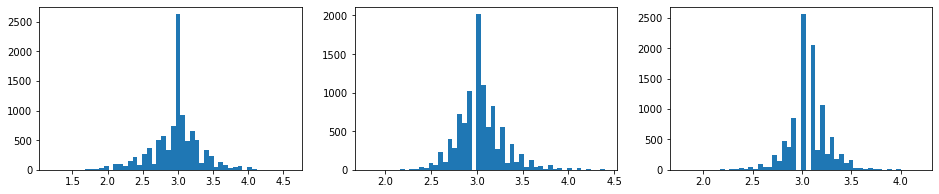

In [3]:
print('Histograms of Valence, Arousal and Dominance respectively')
valence, arousal, dominance = eb['V'], eb['A'], eb['D']
VAR = [valence, arousal, dominance]
fig, axes = plt.subplots(1,3,figsize=(16,3))
for i, ax in enumerate(axes.flat):
    ax.hist(VAR[i], bins=50) 

## NRC VAD lexicon

[Lexicon from Saif M. Mohammad](http://www.saifmohammad.com/WebPages/lexicons.html)

Obtaining Reliable Human Ratings of Valence, Arousal, and Dominance for 20,000 English Words. Saif M. Mohammad. In Proceedings of the 56th Annual Meeting of the Association for Computational Linguistics, Melbourne, Australia, July 2018.

In [4]:
VAD_words = pd.read_csv("NRC-VAD-Lexicon.txt",sep='\t',header=0, index_col='Word')
VAD_words.head()

,Valence,Arousal,Dominance
Word,,,
aaaaaaah,0.479,0.606,0.291
aaaah,0.520,0.636,0.282
aardvark,0.427,0.490,0.437
aback,0.385,0.407,0.288
abacus,0.510,0.276,0.485


Histograms of Valence, Arousal and Dominance respectively, word level


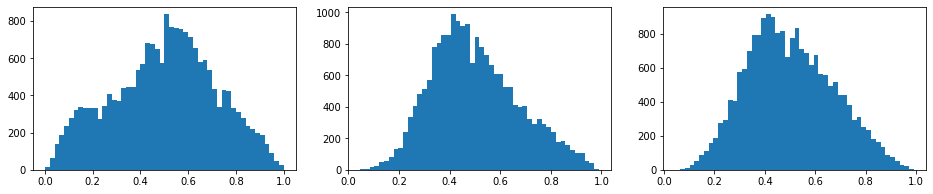

In [5]:
print('Histograms of Valence, Arousal and Dominance respectively, word level')
VAR_w = [VAD_words['Valence'], VAD_words['Arousal'], VAD_words['Dominance']]
fig, axes = plt.subplots(1,3,figsize=(16,3))
for i, ax in enumerate(axes.flat):
    ax.hist(VAR_w[i], bins=50) 

## Let's try different approaches!
Goal is to predict the VAD values of a sentence from its input. Then it would also be great to acquire some model understanding on the way!
## Approach 1 : average of word's VAD value
An intuitive way of facing this problem could be to just take the mean of the VAD values for each word in the sentence. That way, if we had more negative words (valence) the sentence would naturally be more negative. The parameters to learn in this case would be those of the simple linear relation:
$$VADsentence(x_1, x_2, \dots x_n) = a*(VADword(x_1)+VADword(x_2)+ \dots +VADword(x_n))/n+b$$
Notice that they are all 3 component vectors.

In [6]:
def estimate_coef(x, y): 
    # number of observations/points 
    n = np.size(x)
  
    # mean of x and y vector 
    m_x, m_y = np.mean(x), np.mean(y) 
  
    # calculating cross-deviation and deviation about x 
    SS_xy = np.sum(y*x) - n*m_y*m_x 
    SS_xx = np.sum(x*x) - n*m_x*m_x 
  
    # calculating regression coefficients 
    a = SS_xy / SS_xx 
    b = m_y - a*m_x 
  
    return(a, b)

In [7]:
import re
def normalizeString(s):
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [8]:
def get_vec(word):
    #returns vad+300 glove vector
    return VAD_words.loc[word]

In [9]:
def compute_VAD_mean(sentence):
    #takes a string (sentence) and returns the average VAD vector
    sentence = sentence.lower()
    sentence = normalizeString(sentence)
    words = sentence.split()
    vectors = []
    for word in words:
        try:
            vec = [i for i in VAD_words.loc[word][:3]]
            vectors.append(vec)
        except:
            #if word not in the lexicon then it must be neutral
            vectors.append([.5, .5, .5])
    valence = np.mean([vector[0] for vector in vectors])
    arrousal = np.mean([vector[1] for vector in vectors])
    dominance = np.mean([vector[2] for vector in vectors])
    return valence, arrousal, dominance

In [10]:
compute_VAD_mean('Remember what she said in my last letter? "')

(0.5456666666666666, 0.46677777777777785, 0.4773333333333334)

We add columns to keep the VAD average values

In [11]:
eb["V_words"] = ""
eb["A_words"] = ""
eb["D_words"] = ""

In [12]:
for i in range(len(eb)):
    eb['V_words'][i], eb['A_words'][i], eb['D_words'][i] = compute_VAD_mean(eb['text'][i])

Now we only consider the training sentences

In [13]:
train_1 = eb[eb.split=='train']

### Estimating coefficients for valence

In [14]:
a_val, b_val = estimate_coef(train_1['V_words'], train_1['V'])
print('Coefficients for Valence: a = '+str(a_val)+', b = '+str(b_val))

Coefficients for Valence: a = 2.839421168278393, b = 1.454510105282507


### Testing the approach
We will now consider the test set, we'll predict the valence of the text and we'll compare it with the actual value

In [15]:
test_1 = eb[eb.split=='test']
prediction_1_val = []
for i in test_1['V_words']:
    prediction_1_val.append(a_val*i + b_val)

In [16]:
Error_Val = np.absolute((prediction_1_val - test_1['V'].values)).mean()
print('L1 error of approach 1 for valence = '+str(Error_Val))

L1 error of approach 1 for valence = 0.2287386269235124


Lets look at a couple of examples to see if it isn't a generalisation...

In [17]:
for i in [7518, 4949, 7066, 2947]:
    print('--------------------------------------------------------------------------------------')
    val_word = test_1['V_words'][i]
    val, pred = test_1['V'][i], val_word*a_val + b_val
    print(test_1['text'][i])
    print('Valence = {}, predicted valence = {}'.format(val,pred))

--------------------------------------------------------------------------------------
When my father died, a year after my mother, my sisters and I cleaned out their apartment.
Valence = 2.0, predicted valence = 2.9570371401631563
--------------------------------------------------------------------------------------
Outdated baby food found on shelves
Valence = 1.89, predicted valence = 3.217317413922009
--------------------------------------------------------------------------------------
So empty it hurt.
Valence = 2.0, predicted valence = 2.4483075141799446
--------------------------------------------------------------------------------------
"This is a criminal act and it certainly puts things in a different league,"
Valence = 2.0, predicted valence = 2.852316583266413


In [18]:
for i in [4455, 4618, 3871, 2613]:
    print('--------------------------------------------------------------------------------------')
    val_word = test_1['V_words'][i]
    val, pred = test_1['V'][i], val_word*a_val + b_val
    print(test_1['text'][i])
    print('Valence = {}, predicted valence = {}'.format(val,pred))

--------------------------------------------------------------------------------------
And the last lesson -- have fun .
Valence = 4.0, predicted valence = 3.2307708618383764
--------------------------------------------------------------------------------------
Canadian breakthrough offers hope on autism
Valence = 3.88, predicted valence = 3.036067696013572
--------------------------------------------------------------------------------------
We slammed against the doorway and I was laughing too, the pulse close enough to shake the doorframe and set up vibrations in my chest, Rachel in my arms because she’d used me to soften her landing.
Valence = 4.1, predicted valence = 2.8976641154777454
--------------------------------------------------------------------------------------
The proverbial hospitality and warm welcome are still here.
Valence = 3.75, predicted valence = 3.188260670633294


Finally, for arrousal and dominance we have the following errors

In [19]:
a_arr, b_arr = estimate_coef(train_1['A_words'], train_1['A'])
a_dom, b_dom = estimate_coef(train_1['D_words'], train_1['D'])
prediction_1_arr, prediction_1_dom = [], []
for i in test_1['A_words']:
    prediction_1_arr.append(a_arr*i + b_arr)
for i in test_1['D_words']:
    prediction_1_dom.append(a_dom*i + b_dom)
Error_Arr = np.absolute((prediction_1_arr - test_1['A'].values)).mean()
print('L1 error of approach 1 for arrousal = '+str(Error_Arr))
Error_Dom = np.absolute((prediction_1_dom - test_1['D'].values)).mean()
print('L1 error of approach 1 for dominance = '+str(Error_Dom))

L1 error of approach 1 for valence = 0.186054452901469
L1 error of approach 1 for valence = 0.15509522160344397


## Approach 2 : Neural network approach
We can think of this taks as a function that we have to approximate. Neural networks are a nowadays an effective (and popular) way to approximate functions. Since our input corresponds to a sequence of elements (words in this case), then we'll use a recurrent neural network (NRR).

In [20]:
import torch
import csv

Here we'll use [PyTorch](https://pytorch.org/docs/stable/nn.html)

### Sentences to tensors

To represent each word we use the 300 dimensional word vectors from Glove.

[Pre-trained word embedding vectors](https://centralesupelec-my.sharepoint.com/personal/camilo_carvajal_student-cs_fr/_layouts/15/onedrive.aspx?id=%2Fpersonal%2Fcamilo%5Fcarvajal%5Fstudent%2Dcs%5Ffr%2FDocuments%2FCS%2BR%2FPretrained%20word%20vectors&originalPath=aHR0cHM6Ly9jZW50cmFsZXN1cGVsZWMtbXkuc2hhcmVwb2ludC5jb20vOmY6L2cvcGVyc29uYWwvY2FtaWxvX2NhcnZhamFsX3N0dWRlbnQtY3NfZnIvRXJsMG9adkNSLXRFdnNWbnBnUDNKbXdCQzlKbzQxRDVsQVBJZVBNYWJpUERBQT9ydGltZT1LSzZFd0NEaTEwZw)

We load the pickled dataframe

Pennington, J., Socher, R., & Manning, C. D. (2014, October). Glove: Global vectors for word representation. In Proceedings of the 2014 conference on empirical methods in natural language processing (EMNLP) (pp. 1532-1543).

In [21]:
txt = r'C:\Users\fast\camilo\Research_Project\Databases\glove.840B.300d.pkl'
#your path
glove_vecs = pd.read_pickle(txt)
glove_vecs.head()

,1,2,3,4,5,6,7,8,9,10,...,291,292,293,294,295,296,297,298,299,300
0,,,,,,,,,,,,,,,,,,,,,
",",-0.082752,0.672040,-0.14987,-0.064983,0.056491,0.402280,0.002775,-0.331100,-0.306910,2.0817,...,-0.14331,0.018267,-0.18643,0.207090,-0.355980,0.053380,-0.050821,-0.191800,-0.378460,-0.06589
.,0.012001,0.207510,-0.12578,-0.593250,0.125250,0.159750,0.137480,-0.331570,-0.136940,1.7893,...,0.16165,-0.066737,-0.29556,0.022612,-0.281350,0.063500,0.140190,0.138710,-0.360490,-0.03500
the,0.272040,-0.062030,-0.18840,0.023225,-0.018158,0.006719,-0.138770,0.177080,0.177090,2.5882,...,-0.42810,0.168990,0.22511,-0.285570,-0.102800,-0.018168,0.114070,0.130150,-0.183170,0.13230
and,-0.185670,0.066008,-0.25209,-0.117250,0.265130,0.064908,0.122910,-0.093979,0.024321,2.4926,...,-0.59396,-0.097729,0.20072,0.170550,-0.004736,-0.039709,0.324980,-0.023452,0.123020,0.33120
to,0.319240,0.063160,-0.27858,0.261200,0.079248,-0.214620,-0.104950,0.154950,-0.033530,2.4834,...,-0.12977,0.371300,0.18888,-0.004274,-0.106450,-0.258100,-0.044629,0.082745,0.097801,0.25045


To make a sentence we join them into a 2D matrix. However the dimensions are given by:``<line_length x 1 x n_letters>``.

That extra 1 dimension is because PyTorch assumes everything is in
batches - we're just using a batch size of 1 here.

In [22]:
# Turn a line into a <line_length x 1 x n_letters>,

def WordToTensor(word):
    vec_word = [n for n in glove_vecs.loc[word]]
    tensor = torch.FloatTensor(vec_word)
    return tensor

def SentenceToTensor(sentence):
    sentence = sentence.lower()
    sentence = normalizeString(sentence)
    words = sentence.split()
    len_sentence = len(words)
    for word in words:
        try:
            vec_word = glove_vecs.loc[word]
        except:
            len_sentence += -1
    if len_sentence==0:
        return torch.zeros(1, 1, 300)
    tensor = torch.zeros(len_sentence, 1, 300)
    for index, word in enumerate(words):
        tensor[index][0][:] = WordToTensor(word)
    return tensor

In [23]:
hola = SentenceToTensor('what is love?')
hola.size()

torch.Size([4, 1, 300])

In [24]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 600
n_categories = 3
rnn = RNN(300, n_hidden, n_categories)

In [25]:
input = SentenceToTensor('baby dont hurt me')
hidden =torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output, next_hidden)

tensor([[-0.2202, -0.0097,  0.0742]], grad_fn=<AddmmBackward>) tensor([[-1.0166e-02, -1.0015e-01, -2.2861e-02,  2.6831e-01,  1.3063e-01,
         -9.4053e-04,  2.4239e-01, -2.5919e-01, -6.1307e-02, -2.2866e-01,
          2.0585e-01, -2.8933e-02,  9.9936e-03, -2.9961e-02,  4.8870e-02,
         -7.8813e-03,  1.6611e-01,  5.0352e-02,  6.8945e-02,  1.2631e-01,
          1.6805e-01, -1.0975e-01,  3.0740e-02, -2.5084e-02,  8.8976e-02,
          9.3081e-02,  1.1318e-01,  1.9734e-01,  6.3956e-02, -2.3526e-01,
         -1.5554e-02,  4.0989e-02,  9.0401e-02, -4.8504e-02, -8.3495e-03,
         -8.0738e-02,  7.6810e-02, -4.5258e-02, -1.1778e-01,  9.1672e-03,
          1.8153e-02, -2.8526e-02, -1.5026e-01,  7.9682e-02,  2.3485e-01,
          4.4604e-02,  5.5264e-02, -7.7435e-02,  2.3331e-01, -1.9547e-01,
         -1.7859e-01, -7.1762e-02, -4.2446e-02,  3.0213e-01,  1.9971e-01,
         -1.5021e-01,  4.6005e-02,  5.3127e-02,  8.8054e-02,  4.3298e-02,
          6.3428e-02,  1.8832e-01, -7.0685e-02, -

Now we define the loss function

In [26]:
criterion = torch.nn.MSELoss()

Prepare training and test set, defining auxiliary functions

In [27]:
test_2 = test_1.drop(['V_words', 'A_words', 'D_words'], axis=1)
train_2 = train_1.drop(['V_words', 'A_words', 'D_words'], axis=1)
train_2.head()

,split,V,A,D,text
0,train,3.00,3.00,3.20,"Remember what she said in my last letter? """
2,train,3.00,3.00,3.00,".."""
3,train,3.44,3.00,3.22,Goodwill helps people get off of public assistance.
4,train,3.55,3.27,3.46,Sherry learned through our Future Works class that she could rise out of the mire of the welfare system and support ...
5,train,3.60,3.30,3.80,Coming to Goodwill was the first step toward my becoming totally independent.


In [28]:
import random

def randomChoice(dataFrame):
    return dataFrame.loc[random.choice(dataFrame.index)]

def randomTrainingExample():
    row = randomChoice(train_2)
    try:
        VAD = [row.V, row.A, row.D]
        tensor_VAD = torch.FloatTensor([[VAD]])
        sentence = row.text
        tensor_sentence = SentenceToTensor(sentence)
    except:
        sentence, VAD, tensor_sentence, tensor_VAD = randomTrainingExample()
    return sentence, VAD, tensor_sentence, tensor_VAD

In [29]:
def randomTestExample():
    row1, row2, row3 = randomChoice(test_2), randomChoice(test_2), randomChoice(test_2)
    row4, row5 = randomChoice(test_2), randomChoice(test_2)
    tensor_sentence_tests, VAD_tests = [], []
    for row in [row1, row2, row3, row4, row5]:
        try:
            VAD = [row.V, row.A, row.D]
            tensor_VAD = torch.FloatTensor([[VAD]])
            sentence = row.text
            tensor_sentence = SentenceToTensor(sentence)
            tensor_sentence_tests.append(tensor_sentence)
            VAD_tests.append(tensor_VAD)
        except:
            nothing = True
    return tensor_sentence_tests, VAD_tests

We define an evaluation function to constantly test the network while training, but we will use it later to do the overall evaluation and to predict valence for new examples

In [30]:
def evaluate(sentence_tensor):
    hidden = rnn.initHidden()

    for i in range(sentence_tensor.size()[0]):
        output, hidden = rnn(sentence_tensor[i], hidden)

    return output.data[0]

we will evaluate constantly how are function is performing on 5 random test sentences

In [31]:
def test_while_training():
    tensor_sentence_tests, VAD_tests = randomTestExample()
    sum_error = 0
    #test_2_val, test_2_arr, test_2_dom = [], [], []
    for i in range(len(tensor_sentence_tests)):
        #pred_val, pred_arr, pred_dom = evaluate(s_t)[0], evaluate(s_t)[1], evaluate(s_t)[2]
        output = evaluate(tensor_sentence_tests[i])
        sum_error += criterion(output, VAD_tests[i])
    #Error_Val = ((test_2_val - VAD_tests)**2).mean()
    #Error_Arr = ((test_2_arr - VAD_.values)**2).mean()
    #Error_Dom = ((test_2_dom - test_2['D'].values).mean()
    return sum_error/len(tensor_sentence_tests)

In [32]:
#just a function to save room on the examples to show while training
def portionSentence(string,limit=20):
    if len(string)<limit:
        return string
    else:
        new_str = string[:limit]+' ...'
        return new_str
portionSentence('Never gonna give you up, Never gonna let you down')

'Never gonna give you ...'

### Training!
Or loading pre-trained model...

In [33]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(VAD_tensor, Sentence_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(Sentence_tensor.size()[0]):
        output, hidden = rnn(Sentence_tensor[i], hidden)

    loss = criterion(output, VAD_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [34]:
import time
import math

if load_pre_trained==False:
    n_iters = 20000
    print_every = 100
    plot_every = 50

    # Keep track of losses for plotting
    current_loss = 0
    all_losses = []
    test_loss = []

    def timeSince(since):
        now = time.time()
        s = now - since
        m = math.floor(s / 60)
        s -= m * 60
        return '%dm %ds' % (m, s)

    start = time.time()

    for iter in range(1, n_iters + 1):
        sentence, VAD, tensor_sentence, tensor_VAD = randomTrainingExample()
        output, loss = train(tensor_VAD, tensor_sentence)
        current_loss += loss

        # Print iter number, loss, name and guess
        if iter % print_every == 0:
            print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100,  timeSince(start), loss, 
                                                    portionSentence(sentence), output.data[0], VAD))

        # Add current loss avg to list of losses
        if iter % plot_every == 0:
            all_losses.append(current_loss / plot_every)
            current_loss = 0
            test_loss.append(test_while_training())
else:
    rnn.load_state_dict(torch.load('C:\\Users\\fast\\camilo\\ST7\\rnn_VAD.pt'))
    #with the corresponding correct path
        

100 0% (1m 16s) 0.0841 Sure. / tensor([2.5340, 2.4967, 2.6225]) [2.9, 2.7, 2.9]
200 1% (2m 49s) 0.1945 Poverty is frequentl ... / tensor([3.1926, 2.9821, 3.1789]) [2.5, 3.25, 3.0]
300 1% (4m 21s) 0.0521 First of America, wh ... / tensor([3.1114, 2.8400, 3.1627]) [3.2, 3.2, 3.3]
400 2% (6m 1s) 0.1480 I was noodling on Va ... / tensor([2.8969, 2.6542, 2.9484]) [3.1, 3.1, 3.4]
500 2% (7m 31s) 0.0920 The effects of Spani ... / tensor([3.1811, 3.2759, 3.1321]) [2.86, 2.86, 3.14]
600 3% (9m 4s) 0.2342 The vampire fell for ... / tensor([3.0307, 3.1321, 3.0867]) [2.38, 3.38, 2.62]
700 3% (10m 30s) 0.0158 I wondered why, if h ... / tensor([2.6677, 2.9081, 2.7592]) [2.62, 3.12, 2.75]
800 4% (12m 3s) 0.1545 Enough. / tensor([2.5722, 2.7122, 2.7082]) [2.78, 3.11, 3.22]
900 4% (13m 36s) 0.1572 House passes anti-te ... / tensor([2.4436, 2.7338, 2.5333]) [3.0, 2.9, 2.9]
1000 5% (15m 13s) 0.0100 Portugal’s very prec ... / tensor([3.0874, 3.1324, 3.0705]) [3.0, 3.0, 3.0]
1100 5% (16m 46s) 0.1234 Jade. 

8200 41% (124m 0s) 0.0461 If I am capable of l ... / tensor([3.2685, 3.1517, 3.1835]) [3.56, 3.33, 3.33]
8300 41% (125m 27s) 0.0023 Presumably after bei ... / tensor([2.9641, 2.8301, 2.9435]) [2.9, 2.8, 2.9]
8400 42% (127m 2s) 0.1206 She gave me a grumpy ... / tensor([2.8244, 3.0764, 3.0406]) [2.25, 3.25, 3.0]
8500 42% (128m 39s) 0.0402 It tells viewers: Ah ... / tensor([2.9617, 3.0946, 3.1223]) [3.3, 3.1, 3.2]
8600 43% (130m 15s) 0.0481 And proof that Bush  ... / tensor([2.8336, 2.9033, 3.0400]) [2.6, 3.2, 3.0]
8700 43% (131m 42s) 0.1458 When I was done ment ... / tensor([2.9926, 2.9340, 2.9773]) [2.7, 3.5, 2.8]
8800 44% (133m 26s) 0.1126 Fermentation: The Da ... / tensor([3.3433, 3.0568, 3.3045]) [3.0, 2.7, 3.0]
8900 44% (135m 10s) 0.0129 In his book The Symp ... / tensor([2.9815, 3.0551, 3.1189]) [3.0, 2.9, 3.0]
9000 45% (136m 41s) 0.0119 Kun Iam Tong, off Av ... / tensor([3.4063, 3.1795, 3.1709]) [3.4, 3.1, 3.0]
9100 45% (138m 11s) 0.0209 One search does not  ... / tensor([2.8985, 

16200 81% (247m 28s) 0.0184 On its front gripper ... / tensor([2.9707, 3.0070, 3.0543]) [3.0, 2.88, 3.25]
16300 81% (248m 55s) 0.0825 Kitsch is vicarious  ... / tensor([2.8504, 3.1434, 2.9833]) [2.5, 2.8, 2.9]
16400 82% (250m 29s) 0.3574 That is potentially  ... / tensor([3.2622, 2.9783, 3.1271]) [2.27, 3.18, 2.91]
16500 82% (252m 6s) 0.0166 Surrounded by acres  ... / tensor([3.1350, 2.9494, 3.0959]) [3.0, 2.8, 3.0]
16600 83% (253m 41s) 0.0198 But to the thousands ... / tensor([2.8274, 2.9354, 3.0600]) [2.6, 3.0, 3.0]
16700 83% (255m 20s) 0.0118 Zheng, short and dar ... / tensor([2.9895, 2.9566, 2.9485]) [3.1, 3.1, 3.0]
16800 84% (256m 53s) 0.0240 She reached for anot ... / tensor([2.8823, 2.9299, 2.9592]) [3.0, 2.75, 3.12]
16900 84% (258m 22s) 0.0934 With your increased  ... / tensor([2.9145, 2.9102, 3.0236]) [3.1, 3.4, 3.1]
17000 85% (259m 46s) 0.0707 "Oh?" / tensor([2.8717, 3.0300, 3.0271]) [2.9, 3.4, 3.3]
17100 85% (261m 14s) 0.0110 Because the same gen ... / tensor([3.0784, 2.9594

No handles with labels found to put in legend.


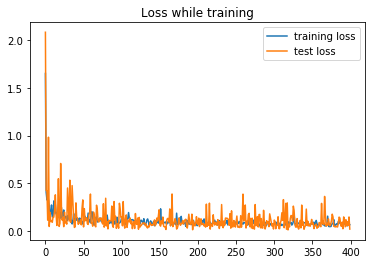

In [35]:
import matplotlib.ticker as ticker

if not load_pre_trained:
    fig = plt.figure()
    ax = plt.subplot(111)
    ax.legend()
    ax.plot(all_losses,label='training loss')
    ax.plot(test_loss,label='test loss')
    plt.title('Loss while training')
    ax.legend()
    plt.show()

In [36]:
prediction_2_val, prediction_2_arr, prediction_2_dom = [], [], []
for i in test_2.index:
    try:
        sentence = test_2['text'][i]
        s_t = SentenceToTensor(sentence)
        pred_val, pred_arr, pred_dom = evaluate(s_t)[0], evaluate(s_t)[1], evaluate(s_t)[2]
        prediction_2_val.append(pred_val)
        prediction_2_arr.append(pred_arr)
        prediction_2_dom.append(pred_dom)
    except:
        prediction_2_val.append(3.)
        prediction_2_arr.append(3.)
        prediction_2_dom.append(3.)

In [37]:
Error_Val = np.absolute(prediction_2_val - test_2['V'].values).mean()
print('L1 error of approach 1 for valence = '+str(Error_Val))
Error_Val = np.absolute(prediction_2_arr - test_2['A'].values).mean()
print('L1 error of approach 1 for arrousal = '+str(Error_Val))
Error_Val = np.absolute(prediction_2_dom - test_2['D'].values).mean()
print('L1 error of approach 1 for dominance = '+str(Error_Val))

L1 error of approach 1 for valence = 0.2626469714832306
L1 error of approach 1 for arrousal = 0.21056396457195284
L1 error of approach 1 for dominance = 0.17682739300727848


In [44]:
for i in [7518, 4949, 7066, 2947]:
    print('--------------------------------------------------------------------------------------')
    sentence = test_2['text'][i]
    s_t = SentenceToTensor(sentence)
    pred_val, pred_arr, pred_dom = evaluate(s_t)[0], evaluate(s_t)[1], evaluate(s_t)[2]
    val, arr, dom  = test_2['V'][i], test_2['A'][i], test_2['D'][i]
    print(test_1['text'][i])
    print('Valence = {}, predicted valence = {}'.format(val,pred_val))
    print('Arrousal = {}, predicted arrousal = {}'.format(arr,pred_arr))
    print('Dominance = {}, predicted dominance = {}'.format(val,pred_dom))

--------------------------------------------------------------------------------------
When my father died, a year after my mother, my sisters and I cleaned out their apartment.
Valence = 2.0, predicted valence = 2.72741436958313
Arrousal = 2.78, predicted arrousal = 3.115412950515747
Dominance = 2.0, predicted dominance = 3.0445940494537354
--------------------------------------------------------------------------------------
Outdated baby food found on shelves
Valence = 1.89, predicted valence = 2.974700927734375
Arrousal = 3.22, predicted arrousal = 3.196429491043091
Dominance = 1.89, predicted dominance = 3.132033348083496
--------------------------------------------------------------------------------------
So empty it hurt.
Valence = 2.0, predicted valence = 2.493443012237549
Arrousal = 3.25, predicted arrousal = 3.032355785369873
Dominance = 2.0, predicted dominance = 3.021170139312744
--------------------------------------------------------------------------------------
"This i

In [45]:
for i in [4455, 4618, 3871, 2613]:
    print('--------------------------------------------------------------------------------------')
    sentence = test_2['text'][i]
    s_t = SentenceToTensor(sentence)
    pred_val, pred_arr, pred_dom = evaluate(s_t)[0], evaluate(s_t)[1], evaluate(s_t)[2]
    val, arr, dom  = test_2['V'][i], test_2['A'][i], test_2['D'][i]
    print(test_1['text'][i])
    print('Valence = {}, predicted valence = {}'.format(val,pred_val))
    print('Arrousal = {}, predicted arrousal = {}'.format(arr,pred_arr))
    print('Dominance = {}, predicted dominance = {}'.format(val,pred_dom))

--------------------------------------------------------------------------------------
And the last lesson -- have fun .
Valence = 4.0, predicted valence = 3.11696195602417
Arrousal = 3.14, predicted arrousal = 3.094287157058716
Dominance = 4.0, predicted dominance = 3.156259059906006
--------------------------------------------------------------------------------------
Canadian breakthrough offers hope on autism
Valence = 3.88, predicted valence = 2.9939565658569336
Arrousal = 3.5, predicted arrousal = 2.6970303058624268
Dominance = 3.88, predicted dominance = 2.9542040824890137
--------------------------------------------------------------------------------------
We slammed against the doorway and I was laughing too, the pulse close enough to shake the doorframe and set up vibrations in my chest, Rachel in my arms because she’d used me to soften her landing.
Valence = 4.1, predicted valence = 2.611011028289795
Arrousal = 3.8, predicted arrousal = 2.972097396850586
Dominance = 4.1, pr

## User input
And then we can just try to predict any sentence...

In [46]:
def VAD_sentence(sen):
    print('--------------------------------------------------------------------------------------')
    s_t = SentenceToTensor(sen)
    val, arr, dom = evaluate(s_t)[0], evaluate(s_t)[1], evaluate(s_t)[2]
    print('Evaluating the following sentence = '+sen)
    print('Valence = {}, Arrousal = {}, Dominance = {}'.format(val,arr,dom))

In [47]:
#write your sentence here
sentence = 'im tired of being locked in'
VAD_sentence(sentence)

--------------------------------------------------------------------------------------
Evaluating the following sentence = im tired of being locked in
Valence = 2.068488597869873, Arrousal = 2.7384531497955322, Dominance = 2.434692859649658


**Can we turn these values into emotions?**

## Saving Model

In [49]:
if not load_pre_trained:
    torch.save(rnn.state_dict(), 'C:\\Users\\fast\\camilo\\ST7\\rnn_VAD.pt')